# 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import pipeline, BertForMaskedLM

# required due to a package conflict in my environment
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

c:\Users\Paul\anaconda3\envs\b0rt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# reloading BERT from source
if False:
    from transformers import BertTokenizer, BertConfig
    model_name = 'bert-base-uncased'
    model = BertForMaskedLM.from_pretrained(model_name)
    tokenizer = BertTokenizer.from_pretrained(model_name)
    config = BertConfig.from_pretrained(model_name)
    model.save_pretrained("bert_orig")
    tokenizer.save_pretrained("bert_orig")
    config.save_pretrained("bert_orig")

# 2. Book titles for masked language modeling

In [2]:
mask_answers = ["witch","pride","kill","wrath","young","hundred","monte","search",
                "war","punishment","rises","madame","heights","being","streetcar",
                "glass","rex","much","nest","lord","catcher","adventures",
                "chocolate","cities"]

masked_titles = ["the lion the [MASK] and the wardrobe.",
"[MASK] and prejudice.",
"to [MASK] a mockingbird.",
"the grapes of [MASK].",
"a portrait of an artist as a [MASK] man.",
"one [MASK] years of solitude.",
"the count of [MASK] cristo.",
"in [MASK] of lost time.",
"[MASK] and peace.",
"crime and [MASK].",
"the sun also [MASK].",
"[MASK] bovary.",
"wuthering [MASK].",
"the importance of [MASK] earnest.",
"a [MASK] named desire.",
"the [MASK] menagerie.",
"oedipus [MASK].",
"[MASK] ado about nothing.",
"one flew over the cuckoo's [MASK].",
"the [MASK] of the rings.",
"the [MASK] in the rye.",
"alice's [MASK] in wonderland.",
"charlie and the [MASK] factory.",
"a tale of two [MASK]."]


# 3. Functions to alter model and make predictions

In [3]:

# Makes predictions for MLM, with some random fraction of parameters set to zero
def b0rt_pred(zero_frac=0, layers=[], layer_type='attention_only'):

    model_zeros = BertForMaskedLM.from_pretrained("bert_orig")

    # convert to string for comparison with layer names
    if len(layers)>0:
        layers = ["layer." + str(l) + "." for l in layers]
    
    if layer_type=='embedding_only':
        layer_shapes = [torch.Size([30522,768])]
    elif layer_type=='attention_only':
        layer_shapes = [torch.Size([768,768]), torch.Size([3072, 768]), torch.Size([768, 3072])]

    with torch.no_grad(): 
        for i, (name, weight) in enumerate(model_zeros.named_parameters()):
            if (weight.shape in layer_shapes) and name!="cls.predictions.transform.dense.weight":
                if len(layers)==0 or any([l in name for l in layers]):
                    weight.data = weight.data * torch.bernoulli(torch.ones(weight.shape),1-zero_frac)

    # save and make predictions for masked titles
    model_zeros.save_pretrained("b0rt_zero")
    plz = pipeline('fill-mask', model='b0rt_zero')
    top_results = []
    for phrase in masked_titles:
        top_results.append(pd.DataFrame.from_dict(plz(phrase)))

    return pd.concat(top_results).reset_index(drop=True)

# Calculates MLM accuracy, takes the top predictions compares it against true answer
def calc_accuracy(top_results,n=1):
    return 100*sum([a==q for a, q in zip(mask_answers, list(top_results.iloc[::5]['token_str'].values))])/len(mask_answers)/n

# How does model performance degrade as more parameters are set to 0?
def randomly_zero_params(layer_type='attention_only'):
    results = []
    for zero_frac in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        pct_correct = []
        for _ in range(10):
            top_preds = b0rt_pred(zero_frac, layer_type=layer_type)
            pct_correct.append(calc_accuracy(top_preds))
        results.append(np.mean(pct_correct))

    results_df = pd.DataFrame(results, index=np.arange(0.05,0.55,step=0.05))
    return results_df

# How does model performance degrade as layers are set to 0?
def randomly_zero_layers():
    results = []
    for no_layers in range(11):
        pct_correct = []
        for _ in range(10):
            layers_to_zero = np.random.choice(np.arange(12),size=no_layers+1,replace=False).tolist()
            top_preds = b0rt_pred(zero_frac=1, layers=layers_to_zero)
            pct_correct.append(calc_accuracy(top_preds))
        results.append(np.mean(pct_correct))
    
    return pd.DataFrame(results, index=np.arange(1,no_layers+2))


In [4]:
# calculate BERT-base results
baseline_results = b0rt_pred()
baseline_results[::5]

,score,token,token_str,sequence
0,0.574544,6965,witch,the lion the witch and the wardrobe.
5,0.985683,6620,pride,pride and prejudice.
10,0.398245,3102,kill,to kill a mockingbird.
15,0.993164,14532,wrath,the grapes of wrath.
20,0.953002,2402,young,a portrait of an artist as a young man.
25,0.717116,3634,hundred,one hundred years of solitude.
30,0.999168,10125,monte,the count of monte cristo.
35,0.339181,3945,search,in search of lost time.
40,0.552003,2162,war,war and peace.
45,0.448878,7750,punishment,crime and punishment.


# 4. Analyze impact of setting parameters to zero

<Axes: title={'center': 'Accuracy vs. fraction of params set to zero'}, xlabel='Fraction zero', ylabel='Accuracy (%)'>

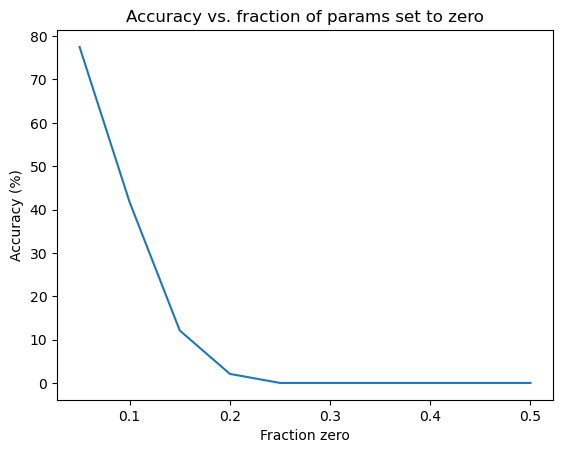

In [5]:
# Randomly set transformer block attention weights to zero
results_df = randomly_zero_params(layer_type='attention_only')
results_df.plot(title="Accuracy vs. fraction of params set to zero",
                xlabel="Fraction zero", ylabel="Accuracy (%)", legend=False)


In [6]:
results_df

,0
0.05,77.500000
0.10,41.666667
0.15,12.083333
0.20,2.083333
0.25,0.000000
0.30,0.000000
0.35,0.000000
0.40,0.000000
0.45,0.000000
0.50,0.000000


<Axes: title={'center': 'Accuracy vs. number of layers set to zero'}, xlabel='Number of layers', ylabel='Accuracy (%)'>

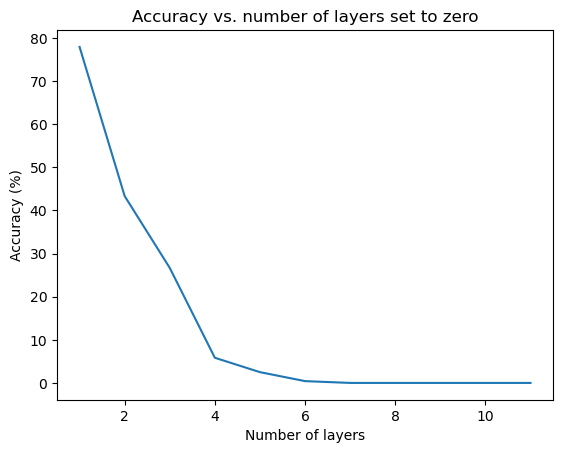

In [7]:
# Randomly select entire layer and set all attention weights to zero
results_df = randomly_zero_layers()
results_df.plot(title="Accuracy vs. number of layers set to zero",
                xlabel="Number of layers", ylabel="Accuracy (%)", legend=False)

In [8]:
results_df

,0
1,77.916667
2,43.333333
3,26.666667
4,5.833333
5,2.500000
6,0.416667
7,0.000000
8,0.000000
9,0.000000
10,0.000000


<Axes: title={'center': 'Accuracy vs. fraction of embedding params set to zero'}, xlabel='Fraction zero', ylabel='Accuracy (%)'>

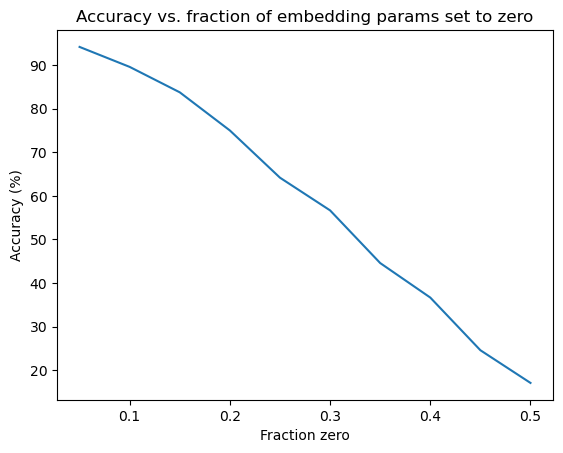

In [9]:
# Randomly set embedding weights to zero
results_df = randomly_zero_params(layer_type='embedding_only')
results_df.plot(title="Accuracy vs. fraction of embedding params set to zero",
                xlabel="Fraction zero", ylabel="Accuracy (%)", legend=False)

In [10]:
results_df

,0
0.05,94.166667
0.10,89.583333
0.15,83.750000
0.20,75.000000
0.25,64.166667
0.30,56.666667
0.35,44.583333
0.40,36.666667
0.45,24.583333
0.50,17.083333
